`torch_dtype` is deprecated! Use `dtype` instead!
2025-11-11 17:44:47.349693: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[INFO] Loaded Qwen/Qwen2.5-3B-Instruct on cuda


Prompts:  20%|██        | 1/5 [00:01<00:05,  1.30s/it]

[INFO] Saved saliency for prompt 1


Prompts:  40%|████      | 2/5 [00:01<00:02,  1.30it/s]

[INFO] Saved saliency for prompt 2


Prompts:  60%|██████    | 3/5 [00:02<00:01,  1.74it/s]

[INFO] Saved saliency for prompt 3


Prompts:  80%|████████  | 4/5 [00:02<00:00,  2.08it/s]

[INFO] Saved saliency for prompt 4


Prompts: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

[INFO] Saved saliency for prompt 5
[INFO] Saliency extraction complete → saliency/


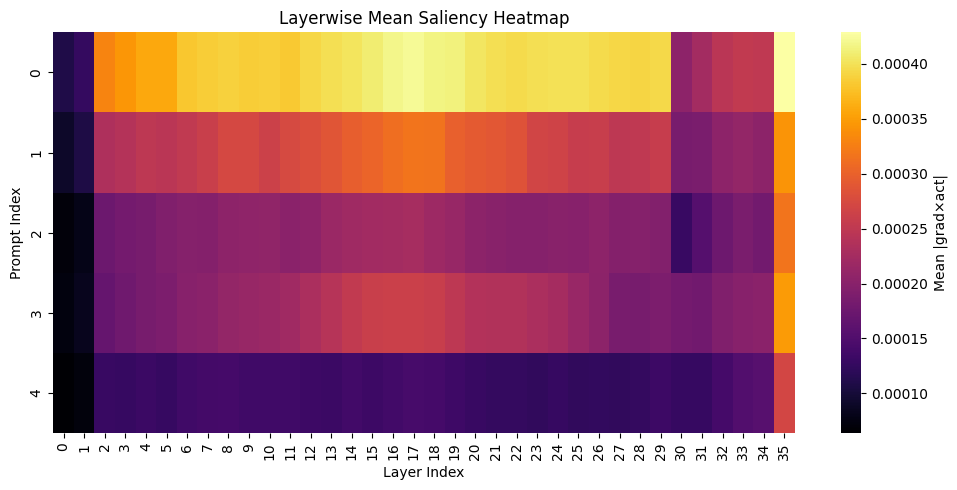

In [1]:
#!/usr/bin/env python3
"""
Phase 4.1 — Saliency Maps via Gradient × Activation
Computes per-layer saliency scores (gradient × activation) for each prompt,
averages across sequence dimension, and visualizes them as heatmaps.
"""

import os, json, torch, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

# ---------------------------------------------------------------------
# 1 — Model loader
# ---------------------------------------------------------------------
def load_model(model_name="Qwen/Qwen2.5-3B-Instruct"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        device_map="auto"
    )
    model.eval()
    print(f"[INFO] Loaded {model_name} on {device}")
    return model, tokenizer, device

# ---------------------------------------------------------------------
# 2 — Hook registration (store activations + gradients)
# ---------------------------------------------------------------------
def register_saliency_hooks(model, store):
    handles = []
    for idx, layer in enumerate(model.model.layers):
        def forward_hook(module, inp, out, layer_idx=idx):
            store[layer_idx] = {"act": out[0].detach().cpu(), "grad": None}
        def backward_hook(module, grad_input, grad_output, layer_idx=idx):
            if layer_idx in store:
                store[layer_idx]["grad"] = grad_output[0].detach().cpu()
        handles.append(layer.register_forward_hook(forward_hook))
        handles.append(layer.register_full_backward_hook(backward_hook))
    return handles

# ---------------------------------------------------------------------
# 3 — Compute saliency maps
# ---------------------------------------------------------------------
def compute_saliency(model, tokenizer, device, prompts, save_dir="saliency"):
    os.makedirs(save_dir, exist_ok=True)

    for p_idx, prompt in enumerate(tqdm(prompts, desc="Prompts")):
        store = {}
        hooks = register_saliency_hooks(model, store)

        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        model.zero_grad(set_to_none=True)
        outputs = model(**inputs)
        scalar = outputs.logits.mean()
        scalar.backward()

        # gradient × activation → saliency
        for layer_idx, tensors in store.items():
            act, grad = tensors["act"], tensors["grad"]
            if grad is None:  # skip if backward hook missed
                continue
            saliency = (grad * act).mean(dim=1).squeeze(0).numpy()  # (hidden_dim,)
            np.save(f"{save_dir}/prompt{p_idx+1:02d}_layer{layer_idx:02d}_saliency.npy", saliency)

        for h in hooks:
            h.remove()

        print(f"[INFO] Saved saliency for prompt {p_idx+1}")

    print(f"[INFO] Saliency extraction complete → {save_dir}/")

# ---------------------------------------------------------------------
# 4 — Visualization
# ---------------------------------------------------------------------
def visualize_saliency(base_dir="saliency"):
    files = sorted([f for f in os.listdir(base_dir) if "_layer" in f and f.endswith(".npy")])
    prompts = sorted({int(f.split("prompt")[1].split("_")[0]) for f in files})
    layers = sorted({int(f.split("_layer")[1].split("_")[0]) for f in files})

    plt.figure(figsize=(10, 5))
    data = np.zeros((len(prompts), len(layers)))
    for i, p in enumerate(prompts):
        for j, l in enumerate(layers):
            path = f"{base_dir}/prompt{p:02d}_layer{l:02d}_saliency.npy"
            if os.path.exists(path):
                data[i, j] = np.abs(np.load(path)).mean()  # mean absolute saliency
    sns.heatmap(data, cmap="inferno", cbar_kws={'label': 'Mean |grad×act|'})
    plt.xlabel("Layer Index")
    plt.ylabel("Prompt Index")
    plt.title("Layerwise Mean Saliency Heatmap")
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
# 5 — Main
# ---------------------------------------------------------------------
def main():
    # Load latest recommender prompts
    log_dir = "logs"
    log_files = sorted([f for f in os.listdir(log_dir) if f.startswith("recommender_") and f.endswith(".json")])
    latest_log = os.path.join(log_dir, log_files[-1])
    with open(latest_log, "r", encoding="utf-8") as f:
        data = json.load(f)
    prompts = [r["question"] for r in data["records"]]

    model, tokenizer, device = load_model()
    compute_saliency(model, tokenizer, device, prompts)
    visualize_saliency()

if __name__ == "__main__":
    main()


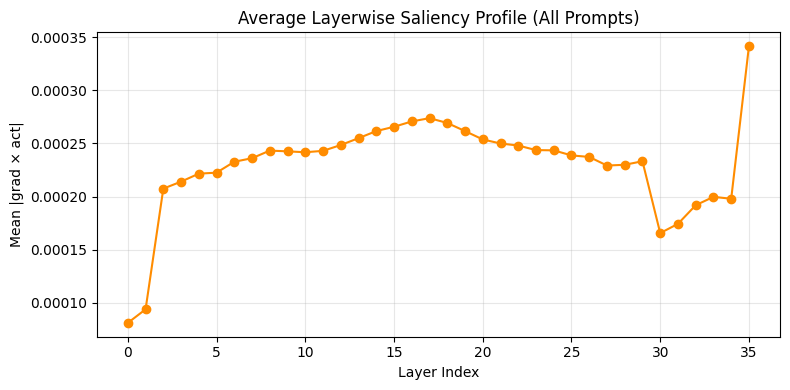

[INFO] Saved top-20 sensitive neurons per layer → sensitive_neurons.json


In [2]:
# ---------------------------------------------------------------------
# 6 — Aggregate Saliency Profiles & Identify Sensitive Neurons
# ---------------------------------------------------------------------
import json

base_dir = "saliency"
files = sorted([f for f in os.listdir(base_dir) if "_layer" in f and f.endswith(".npy")])
prompts = sorted({int(f.split("prompt")[1].split("_")[0]) for f in files})
layers = sorted({int(f.split("_layer")[1].split("_")[0]) for f in files})

# --------------- Compute average saliency per layer ---------------
mean_saliency = []
for l in layers:
    layer_vals = []
    for p in prompts:
        path = f"{base_dir}/prompt{p:02d}_layer{l:02d}_saliency.npy"
        if os.path.exists(path):
            s = np.abs(np.load(path))
            layer_vals.append(s.mean())
    if layer_vals:
        mean_saliency.append(np.mean(layer_vals))
    else:
        mean_saliency.append(np.nan)

# Plot average saliency curve
plt.figure(figsize=(8,4))
plt.plot(layers, mean_saliency, marker="o", color="darkorange")
plt.xlabel("Layer Index")
plt.ylabel("Mean |grad × act|")
plt.title("Average Layerwise Saliency Profile (All Prompts)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --------------- Identify most sensitive neurons per layer ---------------
top_k = 20  # number of neurons to record per layer
sensitive_neurons = {}

for l in layers:
    all_neuron_vals = []
    for p in prompts:
        path = f"{base_dir}/prompt{p:02d}_layer{l:02d}_saliency.npy"
        if os.path.exists(path):
            s = np.abs(np.load(path))
            all_neuron_vals.append(s)
    if not all_neuron_vals:
        continue
    layer_stack = np.vstack(all_neuron_vals)  # shape: (num_prompts, hidden_dim)
    mean_neuron_saliency = layer_stack.mean(axis=0)
    top_indices = np.argsort(mean_neuron_saliency)[-top_k:][::-1]
    sensitive_neurons[f"layer_{l}"] = top_indices.tolist()

# Save to JSON
out_path = "sensitive_neurons.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(sensitive_neurons, f, indent=2)

print(f"[INFO] Saved top-{top_k} sensitive neurons per layer → {out_path}")
